## Population Genetics in *an* RNA World

In order to study population genetics, we first need a model of a population. And even before that, we need to define what we mean by *population*. Populations can be defined on many levels and with many diffferent criteria. For our purposes, we will simply say that a population is a set of individuals sharing a common environment. And because this is population *genetics* we can think of individuals as entities comprising of specific genes or chromosomes. 

So where do we get a population from? As you may have discussed in previous workshops, there are very large datasets containing sequencing information from different populations. So we could download one of these datasets and perform some analysis on it. But I find this can be dry and tedious. Why download data when we can simply create our own?

In this workshop we're going to be creating and studying our own "artificial" populations to illustrate some important population genetics concepts and methodologies. Not only will this help you learn population genetics, but you will get a lot more programming practice than if we were to simply parse data files and go from there. 

More specifically, we're going to build our own RNA world.

As you may know, RNA is widely thought to be the first self replicating life-form to arise billions of years ago. One of the strongest arguments for this theory is that RNA is able to carry information in its nucleotides like DNA, and like protein, it is able to adopt higher order structures to catalyze reactions, such as self replication. So it is likely, and there is growing evidence that this is the case, that the first form of replicating life was RNA. Because of this dual property of RNA as an information vessel as well as a structural/functional element we can use RNA molecules to build very nice population models. 

So in this notebook, I'll be walking you through building genetic populations, simulating their evolution, and using statistics and other mathematical tools for understanding key properties of populations.

### Building an RNA population

As we saw earlier, RNA has the nice property of posessing a strong mapping between information carrying (sequence) and function (structure). This is analogous to what is known in evolutionary terms as a genotype and a phenotype. With these properties, we have everything we need to model a population, and simulate its evolution.

#### RNA sequence-structure

We can think of the genotype as a sequence $s$ consisting of letters/nucleotides from the alphabet $\{U,A,C,G\}$. The corresponding phenotype $\omega$ is the secondary structure of $s$ which can be thought of as a pairing between nucleotides in the primary sequence that give rise to a 2D architecture. Because it has been shown that the function of many biomolecules, including RNA, is driven by structure this gives us a good proxy for phenotype. 

Below is an example of what an RNA secondary structure, or pairing, looks like.

In [1]:
### 1

from IPython.display import Image
#This will load an image of an RNA secondary structure
Image(url='http://www.tbi.univie.ac.at/~pkerp/forgi/_images/1y26_ss.png')

As you can see, unparied positions are forming loop-like structures, and paired positions are forming stem-like structures. It is this spatial arrangement of nucleotides that drives RNA's function. Therefore, another sequence that adopts a similar shape, is likely to behave in a similar manner. Another thing to notice is that, although in reality this is often not the case, in general we only allow pairs between $\{C,G\}$ and $\{A, U\}$ nucleotides, most modern approaches allow for non-canonical pairings and you will find some examples of this in the above structure.

*How do we go from a sequence to a structure?*

So a secondary structure is just a list of pairings between positions. How do we get the optimal pairing?

The algorithm we're going to be using in our simulations is known as the Nussinov Algorithm. The Nussinov algorithm is one of the first and simplest attempts at predicting RNA structure. Because bonds tend to stabilize RNA, the algorithm tries to maximize the number of pairs in the structure and return that as its solution. Current approaches achieve more accurate solutions by using energy models based one experimental values to then obtain a structure that minimizes free energy. But since we're not really concerned with the accuracy of our predictions, Nussinov is a good entry point. Furthermore, the main algorithmic concepts are the same between Nussinov and state of the art RNA structure prediction algorithms. I implemented the algorithm in a separate file called `fold.py` that we can import and use its functions. I'm not going to go into detail here on how the algorithm works because it is beyond the scope of this workshop but there is a bonus exercise at the end if you're curious.

You can predict a secondary structure by calling `nussinov()` with a sequence string and it will return a tuple in the form `(structure, pairs)`.

In [11]:
import numpy as np
from fold import nussinov

sequence_to_fold = "AAAACCCGGGG"
struc = nussinov(sequence_to_fold)
print(sequence_to_fold)
print(struc)

AAAACCCGGGG
('....(....).', [(4, 9)])


You will see a funny dot-bracket string in the output. This is a representation of the structure of an RNA. Quite simply, a matching parir of parentheses (open and close) correspond to the nucleotides at those positions being paried. Whereas, a dot means that that position is unpaired in the structure. Feel free to play around with the input sequence to get a better understanding of the notation.

So that's enough about RNA structure prediction. Let's move on to building our populations.

### Fitness of a sequence: Target Structure

Now that we have a good way of getting a phenotype (secondary structure), we need a way to evaluate the fitness of that phenotype. If we think in real life terms, fitness is the ability of a genotype to replicate into the next generation. If you have a gene carrying a mutation that causes some kind of disease, your fitness is decreased and you have a lower chance of contributing offspring to the next generation. On a molecular level the same concept applies. A molecule needs to accomplish a certain function, i.e. bind to some other molecule or send some kind of signal. And as we've seen before, the most important factor that determines how well it can carry out this function is its structure. So we can imagine that a certain structure, we can call this a 'target' structure, is required in order to accomplish a certain function. So a sequence that folds correctly to a target structure is seen as having a greater fitness than one that does not. Since we've encoded structures as simple dot-bracket strings, we can easily compare structures and thus evaluate the fitness between a given structure and the target, or 'correct' structure. 

There are many ways to compare structures $w_{1}$ and $w_{2}$, but we're going to use one of the simplest ways, which is base-pair distance. This is just the number of pairs in $w_{1}$ that are not in $w_{2}$. Again, this is beyond the scope of this workshop so I'll just give you the code for it and if you would like to know more you can ask me.

In [12]:
### 3

#ss_to_bp() and bp_distance() by Vladimir Reinharz.
def ss_to_bp(ss):
    bps = set()
    l = []
    for i, x in enumerate(ss):
            if x == '(':
                    l.append(i)
            elif x == ')':
                    bps.add((l.pop(), i))
    return bps

def bp_distance(w1, w2):
    """
    return base pair distance between structures w1 and w1. 
    w1 and w1 are lists of tuples representing pairing indices.
    """
    return len(set(w1).symmetric_difference(set(w2)))

#let's fold two sequences
w1 = nussinov("CCAAAAGG")
w2 = nussinov("ACAAAAGA")

print(w1)
print(w2)

#give the list of pairs to bp_distance and see what the distance is.
print(bp_distance(w1[-1], w2[-1]))

('((....))', [(0, 7), (1, 6)])
('.(....).', [(1, 6)])
1


## Defining a cell: a little bit of Object Oriented Programming (OOP)

Since we're going to be playing aroudn with sequences and structures and fitness values a lot, it's best to package it all nicely into an object. As you'll have seen with Vlad, objects are just a nice way of grouping data into an easily accessible form. 

We're trying to simulate evolution on a very simple kind of organism, or cell. It contains two copies of a RNA gene, each with a corresponding structure. 

In [13]:
### 4
class Cell:
    def __init__(self, seq_1, struc_1, seq_2, struc_2):
        self.sequence_1 = seq_1
        self.sequence_2 = struc_1
        self.structure_1 = seq_2
        self.structure_2 = struc_2
        
#for now just try initializing a Cell with made up sequences and structures


## Populations of Cells

Now we've defined a 'Cell'. Since a population is a collection of individuals our populations will naturally consist of **lists** of 'Cell' objects, each with their own sequences. Here we initialize all the Cells with random sequences and add them to the 'population' list.

In [15]:
### 5
import random

def populate(target, pop_size=100):
    
    population = []

    for i in range(pop_size):
        #get a random sequence to start with
        sequence = "".join([random.choice("AUCG") for _ in range(len(target))])
        #use nussinov to get the secondary structure for the sequence
        structure = nussinov(sequence)
        #add a new Cell object to the population list, both chromosomes will be identical to start
        new_cell = Cell(sequence, structure, sequence, structure)
        new_cell.id = i
        new_cell.parent = i
        population.append(new_cell)
            
    return population


In [9]:
import random
nucleotides = [random.choice('AUBLZCG') for _ in range(10)]
print(nucleotides)
"".join(nucleotides)

new_cell = Cell(seq1, struc1, seq1, struc1)

['B', 'Z', 'L', 'C', 'G', 'A', 'G', 'U', 'B', 'L']


'BZLCGAGUBL'

Try creating a new population and printing the first 10 sequences and structures (in dot-bracket) on the first chromosome!

In [16]:
### 6
target = "(.(((....).).).)...."
pop = populate(target, pop_size=100)
for p in pop[:10]:
    print(p.id, p.sequence_1, p.structure_1[0], p.sequence_2, p.structure_2[0])

(0, 'UUCAAGCACGGAUCCCGGCC', 'U', ('.....((.((....).))).', [(5, 18), (6, 17), (8, 16), (9, 14)]), '.....((.((....).))).')
(1, 'UGUCAAUACCUGGAAGCAUA', 'U', ('(((((.....)).)..))..', [(0, 17), (1, 16), (2, 13), (3, 11), (4, 10)]), '(((((.....)).)..))..')
(2, 'CCCUCUAGUCUUCGUCCUGU', 'C', ('(((....).....)....).', [(0, 18), (1, 13), (2, 7)]), '(((....).....)....).')
(3, 'UCAGAUUAGCACGCGUAACA', 'U', ('(..(.((((....).)))))', [(0, 19), (3, 18), (5, 17), (6, 16), (7, 15), (8, 13)]), '(..(.((((....).)))))')
(4, 'CACGGCGAGGCAAAUAGCCA', 'C', ('...(((.(......).))).', [(3, 18), (4, 17), (5, 16), (7, 14)]), '...(((.(......).))).')
(5, 'GUAGAGGGAUACAUUGAAAC', 'G', ('(((((....).).)..)..)', [(0, 19), (1, 16), (2, 13), (3, 11), (4, 9)]), '(((((....).).)..)..)')
(6, 'UUACAGGUAACGACACCCUG', 'U', ('...(((((....)).)..))', [(3, 19), (4, 18), (5, 15), (6, 13), (7, 12)]), '...(((((....)).)..))')
(7, 'CUACAGCGCGGGGCGGACAU', 'C', ('(..(.((....).)))....', [(0, 15), (3, 14), (5, 13), (6, 11)]), '(..(.((....).)))....'

## The Fitness of a Cell

Now that we can store populatoins of cells, we need a way to evaluate the fitness of a given Cell. Recall that a Cell is simply an object that contains two RNA sequences (think of it as two copies of a gene on each chromosome). 

So we simply need to loop through each Cell in a population and compute base pair distance to the target structure. However, simply using base-pair distance is not a very good measure of fitness. There are two reasons for this: 

1. We want fitness to represent a *probability* that a cell will reproduce, and base pair distance is an integer.
2. We want this probability to be a *relative* measure. That is, we want to be the fitness to be proportional to how good a cell is with respect to all others in the population. This touches on an important principle in evolution where we only need to be 'better' than the competition and not good in some absolute measure. For example, if you and I are being chased by a bear. In order to survive, I only need to be faster than you, and not necessarily some absolute level of fitness.

In order to get a probability (number between 0 and 1) we use the following equation to define the fitness of a structure $\omega$ on a target structure $T$:

$$P(\omega, T) = N^{-1} exp(\frac{-\beta \texttt{dist}(\omega, T)}{\texttt{len}(\omega)})$$

$$N = \sum_{i \in Pop}{P(\omega_i, T})$$

Here, the $N$ is what gives us the 'relative' measure because we divide the fitness of the Cell by the sum of the fitness of every other Cell. 

Let's take a quick look at how this function behaves if we plot different base pair distance values.

What is the effect of the parameter $\beta$? Try plotting the same function but with different values of $\beta$.

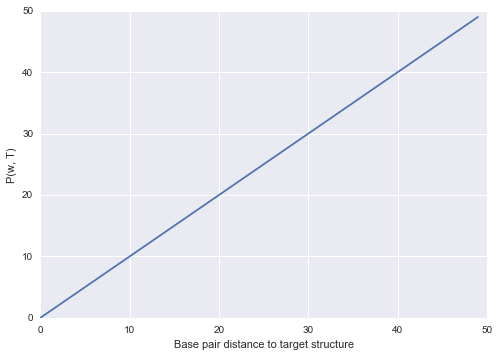

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns

target_length = 50
beta = -2

plt.plot([bp_dist for bp_dist in range(target_length)])
plt.xlabel("Base pair distance to target structure")
plt.ylabel("P(w, T)")

In [10]:
import math
math.exp(bp_dist / target_lelngth)

1.0

As you can see, it's a very simple function that evaluates to 1 (highest fitness) if the base pair distance is 0, and decreases as the structures get further and further away from the target. I didn't include the $N$ in the plotting as it will be a bit more annoying to compute, but it is simply a scaling factor so the shape and main idea won't be different.

Now we can use this function to get a fitness value for each Cell in our population.

In [18]:
### 7

def compute_fitness(population, target, beta=-2):
    """
    Assigns a fitness and bp_distance value to each cell in the population.
    """
    #store the fitness values of each cell
    tot = []
    #iterate through each cell
    for cell in population:
        
        #calculate the bp_distance of each chromosome using the cell's structure
        bp_distance_1 = bp_distance(cell.structure_1[-1], target)
        bp_distance_2 = bp_distance(cell.structure_2[-1], target)
        
        #use the bp_distances and the above fitness equation to calculate the fitness of each chromosome
        fitness_1 = math.exp(beta * float(bp_distance_1) / len(target))
        fitness_2 = math.exp(beta * float(bp_distance_2) / len(target))

        #get the fitness of the whole cell by multiplying the fitnesses of each chromosome
        cell.fitness = fitness_1 * fitness_2
               
        #store the bp_distance of each chromosome.
        cell.bp_distance_1 = bp_distance_1
        cell.bp_distance_2 = bp_distance_2
    
        
        #add the cell's fitness value to the list of all fitness values (used for normalization later)
        tot.append(cell.fitness)

    #normalization factor is sum of all fitness values in population
    norm = np.sum(tot)
    #divide all fitness values by the normalization factor.
    for cell in population:
        cell.fitness = cell.fitness / norm

    return None

compute_fitness(pop, target)
for cell in pop[:10]:
    print(cell.fitness, cell.bp_distance_1, cell.bp_distance_2)

(0.010611254035977674, 4, 7)
(0.0096014597040376942, 4, 8)
(0.01172724936487537, 4, 6)
(0.0086877600079777757, 4, 9)
(0.010611254035977674, 4, 7)
(0.0096014597040376942, 4, 8)
(0.0096014597040376942, 4, 8)
(0.010611254035977674, 4, 7)
(0.0096014597040376942, 4, 8)
(0.0096014597040376942, 4, 8)


## Introducing diversity: Mutations

Evolution would go nowhere without random mutations. While mutations are technically just random errors in the copying of genetic material, they are essential in the process of evolution. This is because they introduce novel diversity to populatons, which with a low frequency can be beneficial. And when a beneficial mutation arises (i.e. a mutation that increases fitness, or replication probability) it quickly takes over the population and the populatioin as a whole has a higher fitness.

Implementing mutations in our model will be quite straightforward. Since mutations happen at the genotype/sequence level, we simply have to iterate through our strings of nucleotides (sequences) and randomly introduce changes.

In [31]:
def mutate(sequence, mutation_rate=0.001):
    """Takes a sequence and mutates bases with probability mutation_rate"""
    
    #start an empty string to store the mutated sequence
    new_sequence = ""
    #boolean storing whether or not the sequence got mutated
    mutated = False
    #go through every bp in the sequence
    for bp in sequence:
        #generate a random number between 0 and 1
        r = random.random()
        #if r is below mutation rate, introduce a mutation
        if r < mutation_rate:
            #add a randomly sampled nucleotide to the new sequence
            new_sequence = new_sequence + random.choice("AUCG")
            mutated = True
        else:
            #if the mutation condition did not get met, copy the current bp to the new sequence
            print(bp)
            new_sequence = new_sequence + bp
            
    return (new_sequence, mutated)

sequence_to_mutate = "AACAGUGUAUGUAUCUAU"
print(sequence_to_mutate)
print(mutate(sequence_to_mutate, mutation_rate=0))

AACAGUGUAUGUAUCUAU
A
A
C
A
G
U
G
U
A
U
G
U
A
U
C
U
A
U
('AACAGUGUAUGUAUCUAU', False)


## Selection

The final process in this evolution model is selection. Once you have populations with a diverse range of fitnesses, we need to select the fittest individuals and let them replicate and contribute offspring to the next generation. In real populations this is just the process of reproduction. If you're fit enough you will be likely to reproduce more than another individual who is not as well suited to the environment.

In order to represent this process in our model, we will use the fitness values that we assigned to each Cell earlier and use that to select replicating Cells. This is equivalent to sampling from a population with the sampling being weighted by the fitness of each Cell. Thankfully, `numpy.random.choice` comes to the rescue here. Once we have sampled enough Cells to build our next generation, we introduce mutations and compute the fitness values of the new generation.

In [32]:
def selection(population, target, mutation_rate=0.001, beta=-2):
    """
    Returns a new population with offspring of the input population
    """

    #select the sequences that will be 'parents' and contribute to the next generation
    #look at the documentation for np.random.choice and its optional argument p
    parents = np.random.choice(population, len(population), p=[cell.fitness for cell in population], replace=True)

    #build the next generation using the parents list
    next_generation = []    
    for i, p in enumerate(parents):
        new_cell = Cell(p.sequence_1, p.structure_1, p.sequence_2, p.structure_2)
        new_cell.id = i
        new_cell.parent = p.id
        
        next_generation.append(new_cell)

    #introduce mutations in next_generation sequeneces and re-fold when a mutation occurs
    for rna in next_generation:      
        mutated_sequence_1, mutated_1 = mutate(rna.sequence_1)
        mutated_sequence_2, mutated_2 = mutate(rna.sequence_2)
        
        #if mutation occured assign and fold the new sequence
        if mutated_1:
            rna.sequence_1 = mutated_sequence_1
            rna.structure_1 = nussinov(mutated_sequence_1)
        if mutated_2:
            rna.sequence_2 = mutated_sequence_2
            rna.structure_2 = nussinov(mutated_sequence_2)
        else:
            continue

    #update fitness values for the new generation
    compute_fitness(next_generation, target, beta=beta)

    return next_generation

next_gen = selection(pop, target)
for cell in next_gen[:10]:
    print(cell.sequence_1)

G
U
G
A
U
G
U
C
U
C
U
C
U
G
C
U
C
G
C
U
G
U
G
A
U
G
U
C
U
C
U
C
U
G
C
U
C
G
C
U
G
G
U
U
G
A
C
A
G
U
U
U
G
U
U
G
G
A
U
C
G
G
U
U
G
A
C
A
G
U
U
U
G
U
U
G
G
A
U
C
U
U
A
U
C
C
G
G
A
A
C
U
G
G
A
A
G
G
A
A
U
U
A
U
C
C
G
G
A
A
C
U
G
G
A
A
G
G
A
A
U
C
G
C
A
U
A
G
U
C
C
U
C
G
U
C
U
A
G
C
U
C
G
C
A
U
A
G
U
C
C
U
C
G
U
C
U
A
G
C
A
C
G
U
C
C
U
C
A
C
G
A
C
G
U
C
C
C
U
A
A
C
G
U
C
C
U
C
A
C
G
A
C
G
U
C
C
C
U
A
G
U
G
U
A
G
C
U
U
U
G
U
A
G
U
C
C
A
C
U
G
U
G
U
A
G
C
U
U
U
G
U
A
G
U
C
C
A
C
U
G
C
C
C
U
G
A
A
C
A
C
A
G
G
C
U
C
C
G
U
G
C
C
C
U
G
A
A
C
A
C
A
G
G
C
U
C
C
G
U
A
G
A
G
C
U
A
C
U
C
A
C
G
U
G
A
C
C
A
U
A
G
A
G
C
U
A
C
U
C
A
C
G
U
G
A
C
C
A
U
A
A
U
A
A
U
G
G
A
G
G
A
G
U
U
C
A
C
U
C
A
A
U
A
A
U
G
G
A
G
G
A
G
U
U
C
A
C
U
C
U
A
C
G
C
G
A
G
U
U
U
U
G
C
U
A
G
A
U
C
U
A
C
G
C
G
A
G
U
U
U
U
G
C
U
A
G
A
U
C
A
G
A
C
A
G
G
C
G
U
G
C
G
U
U
A
A
G
C
G
A
G
A
C
A
G
G
C
G
U
G
C
G
U
U
A
A
G
C
G
G
G
C
G
C
U
G
A
G
U
A
A
A
G
A
C
A
A
A
G
G
G
C
G
C
U
G
A
G
U
A
A
A
G
A
C
A
A
A
G
C
A
C
A
C
U
G
G
A
G
C
G
C
G
C
C
C
G
C
C


## Gathering information on our populations

Here we simply store some statistics (in a dictionary) on the population at each generation such as the average base pair distance and the average fitness of the populations. No coding to do here, it's not a very interesting function but feel free to give it a look.

In [23]:
def record_stats(pop, population_stats):
    """
    Takes a population list and a dictionary and updates it with stats on the population.
    """
    generation_bp_distance_1 = [rna.bp_distance_1 for rna in pop]
    generation_bp_distance_2 = [rna.bp_distance_2 for rna in pop]

    mean_bp_distance_1 = np.mean(generation_bp_distance_1)
    mean_bp_distance_2 = np.mean(generation_bp_distance_2)
    
    mean_fitness = np.mean([rna.fitness for rna in pop])


    population_stats.setdefault('mean_bp_distance_1', []).append(mean_bp_distance_1)
    population_stats.setdefault('mean_bp_distance_2', []).append(mean_bp_distance_2)
    
    population_stats.setdefault('mean_fitness', []).append(mean_fitness)
    
    return None

## And finally.... evolution

We can put all the above parts together in a simple function that does the following:

1. start a new population and compute its fitness
2. repeat the following for the desired number of generations:
    1. record statistics on population
    2. perform selection+mutation
    3. store new population

And that's it! We have an evolutionary reactor!

In [26]:
def evolve(target, generations=10, pop_size=100, mutation_rate=0.001, beta=-2):
    """
    Takes target structure and sets up initial population, performs selection and iterates for desired generations.
    """
    #store list of all populations throughotu generations [[cells from generation 1], [cells from gen. 2]...]
    populations = []
    #start a dictionary that will hold some stats on the populations.
    population_stats = {}
    
    #get a starting population
    initial_population = populate(target)
    #compute fitness of initial population
    compute_fitness(initial_population, target)

    #set current_generation to initial population.
    current_generation = initial_population

    #iterate the selection process over the desired number of generations
    for i in range(generations):

        #let's get some stats on the structures in the populations   
        record_stats(current_generation, population_stats)
        
        #add the current generation to our list of populations.
        populations.append(current_generation)

        #select the next generation
        new_gen = selection(current_generation, target)
        #set current generation to be the generation we just obtained.
        current_generation = new_gen 
    
    return (populations, population_stats)

Try a run of the `evolve()` function.

In [33]:
pops, pops_stats = evolve("(((....)))", generations=20, pop_size=1000, mutation_rate=0.005, beta=-2)

C
U
C
A
U
A
C
C
A
U
C
U
C
A
U
A
C
C
A
U
C
U
G
C
C
A
C
G
U
G
C
U
G
C
C
A
C
G
U
G
A
A
A
G
G
C
C
A
G
G
A
A
A
G
G
C
C
A
G
G
G
G
A
U
U
C
U
U
U
G
G
G
A
U
U
C
U
U
U
G
A
A
A
G
U
A
G
U
A
C
A
A
A
G
U
A
G
U
A
C
G
C
G
G
C
C
C
A
G
C
G
C
G
G
C
C
C
A
G
C
G
U
G
A
G
C
A
G
U
A
G
U
G
A
G
C
A
G
U
A
C
A
A
U
A
C
C
G
U
C
C
A
U
A
C
C
G
U
C
U
C
G
G
A
G
C
A
U
C
U
C
G
G
A
G
C
A
U
C
G
C
G
G
C
C
G
G
G
G
G
C
G
G
C
C
G
G
G
G
U
U
U
G
U
A
A
C
A
U
U
U
U
G
U
A
A
C
A
U
A
G
U
A
C
C
G
A
C
U
A
G
U
A
C
C
G
A
C
U
A
A
U
A
C
A
C
C
A
A
A
A
U
A
C
A
C
C
A
A
U
G
A
C
G
U
G
A
A
A
U
G
A
C
G
U
G
A
A
A
A
A
A
G
U
A
G
U
A
C
A
A
A
G
U
A
G
U
A
C
C
U
C
A
U
A
C
C
A
U
C
U
C
A
U
A
C
C
A
U
C
C
U
U
G
U
G
C
A
A
C
C
U
U
G
U
G
C
A
A
A
U
C
A
A
A
U
C
U
U
A
U
C
A
A
A
U
C
U
U
G
A
G
A
C
U
G
C
U
U
G
A
G
A
C
U
G
C
U
U
U
U
U
G
U
A
A
C
A
U
U
U
U
G
U
A
A
C
A
U
C
U
C
A
U
A
C
C
A
U
C
U
C
A
U
A
C
C
A
U
C
A
G
A
U
U
G
U
G
A
C
A
G
A
U
U
G
U
G
A
A
C
U
A
G
A
G
U
G
U
A
C
U
A
G
A
G
U
G
U
U
U
G
U
A
C
A
A
C
U
U
U
G
U
A
C
A
A
C
U
U
C
A
C
A
A
C
C
A
C
U
C
A
C
A
A
C
C
A
C
U


TypeError: cannot concatenate 'str' and 'list' objects

Let's see if it actually worked by plotting the average base pair distance as a function of generations for both genes in each cell. We should expect a gradual decrease as the populations get closer to the target structure.

In [ ]:
def evo_plot(pops_stats):
    """
    Plot base pair distance for each chromosome over generations.
    """
    for m in ['mean_bp_distance_1', 'mean_bp_distance_2']:
        plt.plot(..., label=m)
    plt.legend()
    plt.xlabel("Generations")
    plt.ylabel("Mean Base Pair Distance")
    
evo_plot(pops_stats)

You should see a nice drop in base pair distance! Another way of visualizing this is by plotting a histogram of the base pair distance of all Cells in the initial population versus the final population.

In [30]:
def bp_distance_distributions(pops):
    """
    Plots histograms of base pair distance in initial and final populations.
    """
    #plot bp_distance_1 for rnas in first population
    g = sns.distplot([rna.bp_distance_1 for rna in pops[0]], label='initial population')
    #plot bp_distance_1 for rnas in first population
    g = sns.distplot([rna.bp_disance_1 for rna in pops[-1]], label='final population')
    g.set(xlabel='Mean Base Pair Distance')
    g.legend()
bp_distance_distributions(pops)

NameError: name 'pops' is not defined

## Studying our evolved sequences with some Population Genetics tools

Now that we've generated some sequences, we can analyze them!

So after several rounds of selection, what do we get? We have a bunch of different sequences. We would like a way to characterize this diversity. One important tool for doing this is by making what is known as phylogenetic trees. 

Phylogenetic trees tell us about which groups of similar sequences are present and how they are likely related in evolutionary time. 

There are several ways of building phylogenetic trees using BioPython. Here we will go over one type and I'll leave another one as an exercise.

### UPGMA (Unweighted Pair Group Method with Arithmetic Means)

This is basically a clustering method based on the distance (or number of differences) between every pair of sequences. It assumes that sequences that are more similar are more likely to be related than the other way around. 

For $N$ sequences, the algorithm builds an $NxN$ matrix that stores the distance between each sequence to every other sequence. The algorithm goes through this matrix and finds the pair of sequences that is most similar and merges it into a 'cluster' or in tree terms, connects them to a common node. This process is repeated until all the sequences have been assigned to a group. Refer to the wikipedia article on [UPGMA](https://en.wikipedia.org/wiki/UPGMA) for a more detailed explanation. 


In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO

In [34]:
sequences = []
#let's take the first 10 sequences of our population to keep things simple
for seq in pops[-1][:20]:
    #store each sequence in the sequences list as a SeqRecord object
    sequences.append(SeqRecord(Seq(seq.sequence_1), id=str(seq.id)))
    

#write our sequences to fasta format
with open("seq.fasta", "w+") as f:
    SeqIO.write(sequences, f, "fasta")

NameError: name 'pops' is not defined

The UPGMA algorithm requires a `MultipleSeqAlignment` object to build the distance matrix. So now that we have the `seq.fasta` file, we can give it to an online multiple sequence alignment tool. We can do this through BioPython but it requires some installation and setup so we will skip that for now. Go to the [MUSCLE Web Server](http://www.ebi.ac.uk/Tools/msa/muscle/) and give it the `seq.fasta` file. It will take a few seconds and it will give you an alignment and click *Download Alignment File*, copy paste the whole thing to a new file called `aln.clustal`. This is the alignment we will use to build our tree.

In [ ]:
#open the alignmnent file
with open("aln.clustal", "r") as aln:
    #use AlignIO to read the alignment file in 'clustal' format
    alignment = AlignIO.read(...)

In [ ]:
from Bio.Phylo.TreeConstruction import DistanceCalculator

#calculate the distance matrix
calculator = DistanceCalculator('identity')
#adds distance matrix based on our alignment to the calculator object and returns it
dm = calculator.get_distance(...)
print(dm)


In [ ]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

#initialize a DistanceTreeConstructor object based on our distance calculator object
constructor = DistanceTreeConstructor(calculator)

#build the tree
upgma_tree = constructor.build_tree(alignment)

In [ ]:
from Bio import Phylo
import pylab
#draw the tree
Phylo.draw(...)

## Introducing mating to the model

The populations we generated evolved asexually. This means that individuals do not mate or exchange genetic information. So to make our simulation a bit more interesting let's let the Cells mate. This is going to require a few small changes in the `selection()` function. Previously, when we selected sequences to go into the next generation we just let them provide one offspring which was a copy of itself and introduced mutations. Now instead of choosing one Cell at a time, we will randomly choose two 'parents' that will mate. When they mate, each parent will contribute one of its chromosomes to the child. We'll repeat this process until we have filled the next generation.

In [ ]:
def selection_with_mating(population, target, mutation_rate=0.001, beta=-2):
    next_generation = []
    
    counter = 0
    while len(next_generation) < len(population):
        #select two parents based on their fitness
        parents_pair = np.random.choice(population, 2, p=[cell.fitness for cell in population])
        
        #take the sequence and structure from the first parent's first chromosome and give it to the child
        child_chrom_1 = (parents_pair[0].sequence_1, parents_pair[0].structure_1)

        #do the same for the child's second chromosome and the second parent.
        child_chrom_2 = (parents_pair[1].sequence_2, parents_pair[1].structure_2)


        #initialize the new child Cell with the new chromosomes.
        child_cell = Cell(child_chrom_1[0], child_chrom_1[1], child_chrom_2[0], chlid_chrom_2[1])

        #give the child and id and store who its parents are
        child_cell.id = counter
        child_cell.parent_1 = parents_pair[0].id
        child_cell.parent_2 = parents_pair[1].id

        #add the child to the new generation
        next_generation.append(child_cell)
        
        counter = counter + 1
            
        
    #introduce mutations in next_generation sequeneces and re-fold when a mutation occurs (same as before)
    for rna in next_generation:      
        mutated_sequence_1, mutated_1 = mutate(rna.sequence_1, mutation_rate=mutation_rate)
        mutated_sequence_2, mutated_2 = mutate(rna.sequence_2, mutation_rate=mutation_rate)

        if mutated_1:
            rna.sequence_1 = mutated_sequence_1
            rna.structure_1 = nussinov(mutated_sequence_1)
        if mutated_2:
            rna.sequence_2 = mutated_sequence_2
            rna.structure_2 = nussinov(mutated_sequence_2)
        else:
            continue

    #update fitness values for the new generation
    compute_fitness(next_generation, target, beta=beta)

    return next_generation    

#run a small test to make sure it works
next_gen = selection_with_mating(pop, target)
for cell in next_gen[:10]:
    print(cell.sequence_1)

Now we just have to update our `evolution()` function to call the new `selection_with_mating()` function.

In [ ]:
def evolve_with_mating(target, generations=10, pop_size=100, mutation_rate=0.001, beta=-2):
    populations = []
    population_stats = {}
    
    initial_population = populate(target, pop_size=pop_size)
    compute_fitness(initial_population, target)
        
    current_generation = initial_population

    #iterate the selection process over the desired number of generations
    for i in range(generations):
        #let's get some stats on the structures in the populations   
        record_stats(current_generation, population_stats)
        
        #add the current generation to our list of populations.
        populations.append(current_generation)

        #select the next generation, but this time with mutations
        new_gen = selection_with_mating(current_generation, target, mutation_rate=mutation_rate, beta=beta)
        current_generation = new_gen 
    
    return (populations, population_stats)

Try out the new evolution model!

In [ ]:
pops_mating, pops_stats_mating = evolve_with_mating("(((....)))", generations=20, pop_size=1000, beta=0)

evo_plot(pops_stats_mating)

## Hardy Weinberg Equilibrium

When we are presented with data from a population we don't know much about. It is often useful to try to learn whether there are any evolutionary or behavioural influences that are shaping population dynamics. This could be in the form of selective pressure, mating preference, genetic drift, mutations, gene flow, etc. So in order to detect if something like this is happening we need to develop a test. This is where Hardy Weinberg comes in. 

The Hardy Weinberg equilibrium states that "allele and genotype frequencies remain constant in the absence of other evolutionary influences. (such as the ones we mentioned above)" - Wikipedia.

So if we can measure allele/genotype frequencies (which we can do because we have sequences), we can see whether the HW principle holds true. If it does not, then we can do more digging to see what could be happening to shift populations away from equilibrium.

In order to do this we need to define an 'allele'. An allele (for our purproses) will be a locus (position in a sequence) that can take one of two states, a *reference* state or an *alternate* state. For example, we can look at locus number **5** (position 5 in our RNA sequences) and call reference **C**, and alternate **G**. If we are in HW we can predict the frequency of each allele in our population.

To simplify our notation we will call the alternate allele *A* and the reference allele *a*. We can write the probability of each allele as $p_{A} + p_{a} = 1$. Since we are dealing with diploid populations, each individual will have two copies of each locus so it can be $p_{AA}, p{Aa}, p{aA}, p{aa}$. By simple probability laws we can get an expression for the probability of each genotype based on the probabilities of the single loci $p_{a}$ and $p_{A}$.

$$p_{aa}\simeq p_{a}^2$$

$$p_{AA}\simeq p_{A}^2$$

$$p_{Aa,~aA} \simeq 2 p_{a} p_{A}.$$

Since it is hard to know what the true probability of observing either $p_{a}$ and $p_{A}$ we can estimate this probability from our data as follows:

$$\hat p_a=\frac{2N_{aa}+N_{aA}}{2N}=1-\hat p_A.$$

Where $N$ denotes the number of each genotype that we observe in our sequences. 

Based on these estimates we can expect the following frequencies for each genotype: 

$N_{aa}\simeq e_{aa}=N \hat p_a^2$

$N_{AA}\simeq e_{AA}= N \hat p_{A}^2$

$N_{Aa,~aA} \simeq e_{Aa} = 2 N \hat p_{a} \hat p_{A}.$

Now we have expected values, and observed values. We need a test to determine whether we have a significant departure from the hypothesis of Hardy Weinberg equilibrium. The statistical test that is commonly used is known as the $\chi^{2}$ test. If you take a look at the equation you'll see that the statistic simply takes the squared difference between our observed value and the expected value (divided by expected) and sums this for each possible genotype. The reason we take the squared difference is because we want to deal only with positive values, hence the name $\chi^{2}$.

$$X^2= \frac{(N_{aa}-e_{aa})^2}{e_{aa}}+ \frac{(N_{Aa}-e_{Aa})^2}{e_{Aa}}+ \frac{(N_{AA}-e_{AA})^2}{e_{AA}}.$$

The first thing we need to do is get alleles from our sequence data. This boils down to going through each sequence at the position of interest and counting the number of $AA$, $Aa$, $aa$ we get.


\** the sections on Hardy Weinberg and F-statistics are adapted from Simon Gravel's HGEN 661 Notes

In [ ]:
def allele_finder(pop, locus, ref, alt):
    genotypes = []
    for p in pop:
        #get the nucleotide at the locus from the first chromosome 
        locus_1 = p.sequence_1[locus].upper()
        #same for the second
        locus_2 = p.sequence_2[locus].upper()
        
        #check that it is either ref or alt, we don't care about other alleles for now.
        if locus_1 in (ref, alt) and locus_2 in (ref, alt):
            #if the alelle is ref, store a value of 1 in allele_1, and 0 otherwise
            allele_1 = ...
            #same for the second allele
            allele_2 = ...
            
            #add allele to our list of alleles as a tuple. 
            genotypes.append(...)
    return genotypes

In [ ]:
pop_hw, stats_hw = evolve_with_mating("(((....)))", pop_size=1000, generations=10, beta=0, mutation_rate=0.005)
alleles = allele_finder(pop_hw[-1], 5,  'C', 'G')
print(alleles[:10])

Now that we have alleles represented in the right form, we can see if our population is at Hardy Weinberg equilibrium using the $\chi_{2}$ test and the equations above.

In [ ]:
from scipy import stats
from scipy.stats import chi2

def hardy_weinberg_chi2_test(alleles):
    
    #store counts for N_AA, N_Aa/aA, N_aa
    hom_ref_count = 0
    het_count = 0
    hom_alt_count = 0
    
    #each allele in the list alleles is in the form (0,0) or (0,1) or (1,0) or (1,1)
    #count how many of each type we have
    for a in alleles:
        if (a[0]==0 and a[1]==0):
            ...
        elif ((a[0]==0 and a[1]==1) or (a[0]==1 and a[1]==0)):
            ...
        elif (...):
            hom_alt_count += 1
        else:
            continue
    
    #total number of genotypes: N
    genotype_count = hom_ref_count + het_count + hom_alt_count

    #estimate p_a, p_A
    alt_counts = (2 * ...) + het_count
    ref_counts = (2 * ...) + het_count
    
    
    #get expectations e_AA, e_aA,Aa, e_aa
    hom_ref_expectation = ref_counts**2 / (4.*genotype_count) # the expected number of homozygote references  
    het_expectation = ref_counts * alt_counts / (2.*genotype_count)  # the expected number of hets  
    hom_alt_expectation = alt_counts**2 / (4.*genotype_count)  # the expected number of homozygote nonreferences  

    #store observed values in list in the form [N_AA, N_aA,Aa, N_aa]
    observations = [hom_ref_count, het_count, hom_alt_count]
    #store expected values in the same form
    expectations = [hom_ref_expectation, het_expectation, hom_alt_expectation]
    
    #start a dictionary that will store our results.
    statistics = {
                'hom_ref': (hom_ref_count, hom_ref_expectation),
                'het': (het_count, het_expectation),
                'hom_alt': (hom_alt_count, hom_alt_expectation), 
                'ref_counts': ref_counts, 
                'alt_counts': alt_counts,
                'genotype_count': genotype_count
                }

    #call scipy function for chi2 test.
    chi_2_statistic = stats.chisquare(observations, f_exp=expectations, ddof=1, axis=0)
    
    #return chi2 and statistics dictionary
    return (chi_2_statistic, statistics)

hardy_weinberg_chi2_test(alleles)

Can we say that our population is at equilibrium? Can you find parameters for `evolution_with_mating()` that will give us populations outside of the HW equilibrium?

## A brief interlude on the p-value

Let's take a minute to understand what the p-value means. The p-value is a probability. Specifically, it is the probability of observing a value equal to or more extreme than that our statistic given the test distribution. So in our case, it is the probability of observing a $X^2$ greater than or equal to the one the test gives us under a $\chi^2$ distribution. When this value is very small, it suggests that it is unlikely that we are sampling from our assumed 'null' distribution and that some other alternate distribution is the true distribution. So a low p-value here would be evidence against the neutral Hardy Weinberg model and would suggest that our population is experiencing some influences such as mating preference, selection, mutation etc.

A lot of research bases its conclusions solely on p-value and it is important to be very wary of this bad practice. It has become a bad convention that people say a p-value lower than some arbitrary threshold means one's findings are significant. However, very often the p-value does not give us the whole story and we need to know about things like sample size, size of impact, reproducibility, power of the test, etc. (check this out [American Statistical Association statement on p-values](http://www.nature.com/news/statisticians-issue-warning-over-misuse-of-p-values-1.19503), [p-hacking](http://fivethirtyeight.com/features/science-isnt-broken/#part1), and [this](http://allendowney.blogspot.ca/2016/06/there-is-still-only-one-test.html))

Let's just visualize this very quickly using the $\chi^{2}_{1}$ distribution. You will see that the p-value corresponds to the shaded red area under the curve. That area is the probability of observing a value as extreme or more than the one we found. When that is a very small area, we can be more confident that our assumption of HW is false.

In [ ]:
#number of samples to take from the x2 distribution.
number_of_samples = 1000

range_points = 2000
range_start = 0

degrees_of_freedom = 1

range_end = chi2.ppf(1-1./number_of_samples, degrees_of_freedom)
                     
x_range = np.linspace(range_start, range_end, range_points) 
plt.plot(x_range, chi2.pdf(x_range, degrees_of_freedom))

#find the index value of our statistic value. you can put in different values here.
statistic = 0.5

#find the index in x_range corresponding to the statistic value (within 0.01)
point = 0
for i, nb in enumerate(x_range):
    if nb < statistic + .01 and nb > statistic - .01:
        point = i

#fill area under the curve representing p-value
plt.fill_between(x_range[point:], chi2.pdf(x_range, degrees_of_freedom)[point:], alpha=0.3, color="red")

plt.xlabel("X-statistic")
plt.ylabel(r"$\chi^2_%d$" % degrees_of_freedom)


## Population structure: F-statistics

The last topic we'll cover is F-statistics. 

Once we find that our population strays from the HW condition we can begin to ask why that is the case. Often this deviation from the expected allele frequencies under HW is due to mating preference. Hardy Weinberg assumes that all individuals in a population have an equal probability of mating with any other individual (random mating). However, when certain individuals prefer to mate with specific others (in real populations this can be due to culture, race, geographic barriers, etc.), you get what is known as population structure. Population structure means that we begin to see *sub-populations* within our total population where individuals prefer to mate within their sub-population. This biased mating will result in a higher number of homozygotes than we would expect under Hardy-Weinberg equilibrium. Simply because mating preferences will tend to drive populations toward similar genotypes. So if this is the case, and no other factors are biasing allele dynamics, within sub-populations we should have Hardy-Weinberg like conditions. 

For example, if Raptors fans prefer to mate with other Raptors fans, then when we consider only Raptors fans, we should observe random mating. Simply because if the mating preference criterion is 'being a Raptor's fan' then any Raptor's fan will be equally likely to mate with any other Raptor's fan so we have Hardy Weinberg again.

Let's express this in quantities we can measure.

From before we calculated the observed and expected number of heterozygotes in a population. Let's call these $\hat H$ and $H_{IT}$ respectively. $\hat H$ is just the count of heterozygotes, and $H_{IT}$ is the same as the expected number of heterozygotes we calculated earlier.

We define a quantity $e_{IT}$ as a measure of the 'excess heterozygosity' in the population when we consider all individuals $I$ in the total population $T$. $e_{IT} > 1$ when we have more heterozygotes than we expect under HW. And $0 < e_{IT} < 1$ if we have less heterozygotes than we would expect under HW.


$$e_{IT}=\frac{\mbox{observed proportion of hets}}{\mbox{expected proportion of hets}}=\frac{ H_{obs}}{H_{IT}}$$

We use $e_{IT}$ to define the statistic $F_{IT}$

$$F_{IT}=1-e_{IT}$$

So $F_{IT} > 0$ when we have a lack of heterozygotes and $F_{IT} < 0$ when we have an excess of heterozygotes. $F_{IT} = 0$ under random mating.

When we have a subpropulation $S$ we can calculate the equivalent quantity but instead of considering heterozygosity in the whole population we only take a sub-population into account.

$$e_{IS} = \frac{H_{obs}}{H_{IS}}$$

And lastly, we have $F_{ST}$. This one is not as intuitive to derive so I'm not including the derivation here. But basically it measure the excess heterozygosity in the total population due to the presence of two subpopulations with allele frequencies $p_{1}$ and $p_{2}$.

$$F_{ST}= \frac{(p_1-p_2)^2}{4 p (1-p)}$$

In [ ]:
def F_statistics(total_pop, sub_pop_1, sub_pop_2):   
    """
    Uses definitions above and allele counts from two sub-populations and a total population to compute F-statistics.
    """
    #recall that the input dictionaries each contain a tuple in the form(observed, expected) for each genotype
    f_IT = 1 - total_pop['het'][0] / (1. * total_pop['het'][1])
    
        
    f_IS_1 = ...
    f_IS_2 = ...   
    
    p1 = sub_pop_1['ref_counts'] / (1. * sub_pop_1['genotype_count'])
    p2 = sub_pop_2['ref_counts'] / (1. * sub_pop_2['genotype_count'])
    
    p = total_pop['ref_counts'] / (1. * total_pop['genotype_count'])
    
    f_ST = ...
    
    F_dict = {
        'f_IT': f_IT,
        'f_IS_1': f_IS_1,
        'f_IS_2': f_IS_2,
        'f_ST': f_ST
    }
    
    return F_dict

Let's get some data for our F-tests. First we need to evolve two populations indepenently of each other, to simulate isolated mating. Then to simulate the total population we combine the two sub-populations. We then use our `allele_finder()` function to get all the alleles, and the `hardy_weinberg_chi_2_test()` function to get our expected and observed counts. Finally we plug those into the `f_statistics()` function.

In [ ]:
generation = -1

#run two independent simulations
sub_pop_1, sub_pop_1_stats= ...
sub_pop_2, sub_pop_2_stats= ...

In [ ]:
#merge the two populations into a total population.
total_pop = sub_pop_1[generation] + sub_pop_2[generation]


#choose a reference and alternate allele
ref_allele = "A"
alt_allele = "G"

#choose the position of the locus of interest.
locus = 1

#get list of alleles for each population
total_pop_alleles = allele_finder(total_pop, locus, ref_allele, alt_allele)
sub_pop_1_alleles = allele_finder(sub_pop_1[generation],locus, ref_allele, alt_allele)
sub_pop_2_alleles = allele_finder(sub_pop_2[generation],locus, ref_allele, alt_allele)

#get homo/het expectations using hardy weinberg function
total_pop_counts = hardy_weinberg_chi2_test(total_pop_alleles)[1]
sub_pop_1_counts = hardy_weinberg_chi2_test(sub_pop_1_alleles)[1]
sub_pop_2_counts = hardy_weinberg_chi2_test(sub_pop_2_alleles)[1]

#call f-statistics function
f_statistics = F_statistics(...)
print(f_statistics)

Try playing with different evolution parameters and see the effect on the different F-statistics. This workshop is a work in progress so there may be some biases in our simulation scheme that can make for come confusing F-statistics. If you come up with anything interesting I would love to know about it.

## Exercises / Extra Material

### Programming Exercises

i. *Heatmap of mutation rates vs. population sizes.* (short) 

Make a heatmap that plots the base pair distance of the average base pair distance of the population at generation `-1` for mutation rates $\mu = \{0, 0.001, 0.01, 0.1, 0.5\}$ and population sizes $N=\{10, 100, 1000, 10000\}$. The resulting heatmap will be `5x4` dimensions. You may choose how many generations to evolve your populations, just plot the last one in the heatmap.

In [ ]:
#lists of mutation rates and population sizes to test
mutation_rates = [0, 0.001, 0.01, 0.1, 0.5]
population_sizes = [10, 100, 1000, 10000]

#number of generations to run each simulation
generations = 1
#target structure
target = "(.((....)))"

...
...
...

ii. *Introduce mating preferences within a population.* (medium length) 

Modify the `selection_with_mating()` function to allow for mating preferences within a population. In our example above we were just running two independent simulations to study barriers to gene flow. But now you will implement mating preferences within a single simulation. Your function will assign each Cell a new attribute called `self.preference` which will take a string value denoting the mating type the current cell prefers to mate with. For example we can have a population with three mating types: $\{A, B, C\}$. Your function will randomly assign preferences to each cell in the initial population. We will define a preference between types $A$ and $B$ as the probability that two cells of those given types will mate if selected. 

$$
preferences(A,B,C) = 
\begin{bmatrix}
   0.7 & 0.1 & 0.2 \\
   0.1 & 0.9 & 0   \\
   0.2 & 0   & 0.8 \\
\end{bmatrix}
$$

Once you selected two potential parents for mating (as we did earlier) you will use the matrix to evaluate whether or not the two parents will mate and contribute an offspring to the next generation. 

In [ ]:
def populate_with_preferences(target, preference_types, pop_size=100):
    
    population = []

    for i in range(pop_size):
        #get a random sequence to start with
        sequence = "".join([random.choice("AUCG") for _ in range(len(target))])
        #use nussinov to get the secondary structure for the sequence
        structure = nussinov(sequence)
        #add a new Cell object to the population list
        new_cell = Cell(sequence, structure, sequence, structure)
        new_cell.id = i
        new_cell.parent = i
        
        #assign preference
        new_cell.preference = random.choice(preference_types)
        population.append(new_cell)
            
    return population

def selection_with_mating_preference(population, target, preference_matrix, preference_types, mutation_rate=0.001, beta=-2):
    next_generation = []
    
    counter = 0
    while len(next_generation) < len(population):
        #select two parents based on their fitness
        parents_pair = np.random.choice(population, 2, p=[rna.fitness for rna in population], replace=False)
        
        #look up probabilty of mating in the preference_matrix
        mating_probability = preference_matrix[...][...]
        
        r = random.random()
        #if random number below mating_probability, mate the Cells as before
        if ...:
            #take the sequence and structure from the first parent's first chromosome and give it to the child
            child_chrom_1 = (parents_pair[0].sequence_1, parents_pair[0].structure_1)

            #do the same for the child's second chromosome and the second parent.
            child_chrom_2 = (parents_pair[1].sequence_2, parents_pair[1].structure_2)


            #initialize the new child Cell witht he new chromosomes.
            child_cell = Cell(child_chrom_1[0], child_chrom_1[1], child_chrom_2[0], child_chrom_2[1])

            #give the child and id and store who its parents are
            child_cell.id = counter
            child_cell.parent_1 = parents_pair[0].id
            child_cell.parent_2 = parents_pair[1].id
            
            #give the child a random preference
            child_cell.preference = random.choice(preference_types)

            #add the child to the new generation
            next_generation.append(child_cell)

            counter = counter + 1
            
        
    #introduce mutations in next_generation sequeneces and re-fold when a mutation occurs (same as before)
    for rna in next_generation:      
        mutated_sequence_1, mutated_1 = mutate(rna.sequence_1, mutation_rate=mutation_rate)
        mutated_sequence_2, mutated_2 = mutate(rna.sequence_2, mutation_rate=mutation_rate)

        if mutated_1:
            rna.sequence_1 = mutated_sequence_1
            rna.structure_1 = nussinov(mutated_sequence_1)
        if mutated_2:
            rna.sequence_2 = mutated_sequence_2
            rna.structure_2 = nussinov(mutated_sequence_2)
        else:
            continue

    #update fitness values for the new generation
    compute_fitness(next_generation, target, beta=beta)

    return next_generation    


def evolve_with_mating_preferences(target, preference_types, preference_matrix,\
                                   generations=10, pop_size=100, mutation_rate=0.001, beta=-2):
    populations = []
    population_stats = {}
    
    initial_population = populate_with_preferences(target, preference_types, pop_size=pop_size)
    compute_fitness(initial_population, target)
        
    current_generation = initial_population

    #iterate the selection process over the desired number of generations
    for i in range(generations):
        #let's get some stats on the structures in the populations   
        record_stats(current_generation, population_stats)
        
        #add the current generation to our list of populations.
        populations.append(current_generation)

        #select the next generation, but this time with mutations
        new_gen = selection_with_mating_preference(current_generation, target, preference_matrix, \
                                                   preference_types, mutation_rate=mutation_rate, beta=beta)
        current_generation = new_gen 
    
    return (populations, population_stats)



#run a small test to make sure it works
target = ".(((....)))"
#for convenience, let's give the preference types integer values in sequential order
preference_types = [0,1,2]

preference_matrix = np.array([[0.7, 0.1, 0.2],[0.1, 0.9, 0],[0.2, 0, 0.8]])
    
pops, pop_stats = evolve_with_mating_preferences(target, preference_types, preference_matrix)

for cell in pops[-1][:10]:
    print(cell.sequence_1)

### Population Genetics / Bioinformatics Exercises

*Exercise 1.  Make a tree using maximum parsimony.*

We saw how to make trees using a distance score. Another popular method is known as the maximum parsimony approach. I won't go into too much detail on this since we are short on time, but I will give a quick intro and we'll look at how ot make a tree using maximum parsimony.

This approach is based on the principle of parsimony, which states that the simplest explanation for our data is the most likely to be true. So given an alignment, we assume that the best tree is the one that minimizes the number of changes, or mutations. This is often a reasonable assumption to make since mutation rates in real populations are generally low, and things like back-mutations (e.g. A --> C --> A) are unlikely. Computing the tree that that maximizes parsimony directly is a difficult task, but evaluating the parsimony score of a tree given the tree is easy. So this approach basically generates many random trees for the data and scores them based on parsimony keeping the most parsimonious tree. Take a look at [the biopython manual to work through this example](http://biopython.org/wiki/Phylo), and [this one](http://biopython.org/DIST/docs/api/Bio.Phylo.TreeConstruction.ParsimonyTreeConstructor-class.html).

Since we already have an alignment (`aln.clustal`) we will just re-use it and make a maximum parsimony tree instead. 

In [ ]:
from Bio.Phylo.TreeConstruction import *

#open our alignment file (or make a new one if you want)
with open('aln.clustal', 'r') as align:
    aln = AlignIO.read(align, 'clustal')

#create a parsimony scorer object
scorer = ParsimonyScorer()
#the searcher object will search through possible trees and score them.
searcher = NNITreeSearcher(scorer)

#takes our searcher object and a seed tree (upgma_tree) to find the best tree
constructor = ParsimonyTreeConstructor(searcher, upgma_tree)

#build the tree 
parsimony_tree = constructor.build_tree(...)

#draw the tree
Phylo.draw(...)

*Exercise 2. Bootstrapping*

We just saw two methods of growing phylogenetic trees given an alignment. However, as we saw with the maximum parsimony approach, there can be many different trees for a single data set. How do we know our tree is a good representation of the data? By 'good' here we will instead use the word 'robust'. Is the tree we use too sensitive to the particularities of the data we gave it? If we make a small change in the sequence will we get a very different tree? Normally these problems would be addressed by re-sampling and seeing if we obtain similar results. But we can't really re-sample evolution. It happened once and we can't make it happen again. So we use something called *bootstrapping* which is a technique often used in statistics where instead of generating new data, you re-sample from your present data.

So we have a multiple sequence alignment with $M$ sequences (rows) each with sequences of length $N$ nucleotides (columns). For each row, we can randomly sample $N$ nucleotides with replacement to make a new 'bootstrapped' sequence also of length $N$. Think of it as a kind of shuffling of the data. This gives us a whole new alignment that we can again use to make a new tree.

This process is repeated many times to obtain many trees. The differences in topology (shape/structure) of the trees we obtained are assessed. If after this shuffling/perturbations we still get similar enough looking trees we can say that our final tree is robust to small changes in the data. ([some more reading on this](http://projecteuclid.org/download/pdf_1/euclid.ss/1063994979))

Let's run a small example of this using the bootstrapping functions in `BioPython`.

Make use of the documentation to help you with this: [here](http://biopython.org/wiki/Phylo) [and here](http://biopython.org/DIST/docs/api/Bio.Phylo.Consensus-module.html)

In [ ]:
from Bio.Phylo.Consensus import *

#open our alignment file.
with open('aln.clustal', 'r') as align:
    aln = AlignIO.read(align, 'clustal')

#take 5 bootstrap samples from our alignment
bootstraps = bootstrap(aln,5)

#let's print each new alignment in clustal format. you should see 5 different alignments.
for b in bootstraps:
    print(b.format('clustal'))

In [ ]:
#now we want to use the bootstrapping to make new trees based on the new samples. we'll go back to making UPGMA trees.

#start a calculator that uses sequence identity to calculate differences
calculator = DistanceCalculator('identity')
#start a distance tree constructor object 
constructor = DistanceTreeConstructor(calculator)
#generate 5 bootstrap UPGMA trees
trees =  ...

#let's look at the trees. (if you have few samples, short sequences the trees might look very similar)
for ...:
    Phylo.draw(...)

In [ ]:
#biopython gives us a useful function that puts all this together by bootstrapping trees and making a 'consensus' tree.
consensus_tree = ...
Phylo.draw(consensus_tree)

*Exercise 3. T-tests*

Similarly to the $\chi^{2}$ test we saw for testing deviations from HW equilibrium, we can use a T-test to compare differences in means between two independent samples. We can use this to revisit a the first programming question in the exercsies section. Does mutation rate and population size have an effect on the fitness of populations? We can translate this question to, is there a difference in the mean base pair distance between populations under different mutation and population size regimes?

Scipy has a very useful function that implements the T-test called `scipy.stats.ttest_ind`. Run two independent simulations (with different mutation rates) and compute the difference in mean bp distance between the two at their final generation. Store the populations in two different variables. Give a list of `bp_distance_1` values for each memeber of the population to `ttest_ind()`. 

Make sure to read teh `ttest_ind()` documentation, particularly about the argumetn `equal_var`. What should we set it to?

In [ ]:
import collections

target = "..(((....).))"

#run two simulations
hi_mut_pop, hi_mut_stats = evolve(target, generations=5, pop_size=1000, mutation_rate=0.5)
lo_mut_pop, hi_mut_stats = evolve(target, generations=5, pop_size=1000, mutation_rate=0.05)

#store lits of base pair distances for each population at last generation.
hi_bps = [... for p in hi_mut_pop[-1]]
lo_bps = [... for p in lo_mut_pop[-1]]

#run the 
stats.ttest_ind(...)

### Bonus! (difficult programming exercise)
1. *Nussinov Algorithm (Only try this if you are feeling brave and are done with the other exercises or are interested in getting a taste of Computer Science. It is beyond the scope of this workshop. If you would like more info or help on this feel free to send me an email!)*

There are several approaches for solving this problem, we will look at the simplest one here which is known as the Nussinov Algorithm. This algorithm is a popular example of a class of algorithms know as dynamic programming algorithms. The main idea behind these algorithms is that we can break down the problem into many subproblems which are easier to compute than the full problem. Once we have obtained the solution for the subproblems, we can retrieve the solution to the full problem by doing something called a backtrace (more on the backtrace later). 

Here, the problem is obtaining the optimal pairing on a string of nucleotides. In order to know how good our structure is, we assign a score to it. One possible scoring scheme could be adding 1 to the score per paired set of nucleotides, and 0 otherwise. So in other words, we want a pairing that will give us the highest possible score. We can write this quantity as $OPT(i, j)$ where $i$ and $j$ are the indices of the sequence between which we obtain the pairing score. Our algorithm is therefore going to compute a folding score for all substrings bound by $i$ and $j$ and store the value in what is known as a dynamic programming table. Our dynamic programming table will be a $N$ x $N$ array where $N$ is the length of our sequence. So now that we have a way of measuring how good a structure is, we need a way to evaluate scores given a subsequence. To do this, we set some rules on the structure of an RNA sequence:


If $i$ and $j$ form a pair:
1. The pair $i$ and $j$ must form a valid watson-crick pair.
2. $i < j-4$. This ensures that bonding is not happening between positions that are too close to each other, which would produce steric clashes.
3. If pair $(i,j)$ and $(k, l)$ are in the structure, then $i < k < j < l$. This ensures that there is no crossing over of pairs which would result in pseudoknots.
4. No base appears in more than one pair.

Using these rules we can begin to build our algorithm. The first part of our algorithm needs to take as input indices $i$ and $j$ and return the value $OPT(i,j)$ which is the optimal score of a structure between $i$ and $j$. We start by thinking about values of $i$ and $j$ for which we can immediately know the solution, this is known as a 'base case'.  This is a case where the solution is known and no further recursion is required. Once the algorithm reaches the base case, it can return a solution and propagate it upward to the first recursive call. So once we have reached $i$ and $j$ that are too close to form a structure (rule number 2), we know that the score is 0. 

Otherwise, we must weigh the possibility of forming a pair or not forming a pair. If $i$ and $j$ are unpaired, then $OPT(i,j)$ is just $OPT(i, j-1)$ since the score will not increase for unpaired indices. 

The other case is that $i$ is paired to some index $t$ on the interval $[i,j]$. We then add 1 to the score and consider the structure formed before and after the pairing between $i$ and $t$. We can write these two cases as $OPT(i, t-1)$ and $OPT(t+1, j)$. But how do we know which $t$ to pair $i$ with? Well we simply try all possible values of $t$ within the allowed range and choose the best one. 

All of this can be summed up as follows:

$$ OPT(i,j) = max\begin{cases}
                OPT(i, j-1) \quad \text{If $i$ and $j$ are not paired with each other.}\\
                max(1 + OPT(i, t-1) + OPT(t+1, j)) \quad \text{Where we try all values of $t$ < j - 4}
                \end{cases}$$


We can now use this recursion to fill our dynamic programming table. Once we have filled the table with scores, we can retrieve the optimal folding by a process called backtracking. We won't go into detail on how this works, but the main idea is that we can start by looking at the entry containing the score for the full sequence $OPT[0][N]$. We can then look at adjacent entries and deduce which case (pairing or not pairing) resulted in the current value. We can continue like this for the full table until we have retrieved the full structure.

In [ ]:
min_loop_length = 4

def pair_check(tup):
    if tup in [('A', 'U'), ('U', 'A'), ('C', 'G'), ('G', 'C')]:
        return True
    return False

def OPT(i,j, sequence):
    """ returns the score of the optimal pairing between indices i and j"""
    #base case: no pairs allowed when i and j are less than 4 bases apart
    if i >= j-min_loop_length:
        ...
    else:
        #i and j can either be paired or not be paired, if not paired then the optimal score is ...
        unpaired = ...

        #check if j can be involved in a pairing with a position t
        pairing = [...]
        if not pairing:
            pairing = [0]
        paired = max(...)


        return max(unpaired, paired)


def traceback(i, j, structure, DP, sequence):
    #in this case we've gone through the whole sequence. Nothing to do.
    if j <= i:
        return
    #if j is unpaired, there will be no change in score when we take it out, so we just recurse to the next index
    elif DP[i][j] == DP[i][j-1]:
        traceback(i, j-1, structure, DP, sequence)
    #hi
    else:
        #try pairing j with a matching index k to its left.
        for k in [b for b in range(i, j-min_loop_length) if pair_check((sequence[b], sequence[j]))]:
            #if the score at i,j is the result of adding 1 from pairing (j,k) and whatever score
            #comes from the substructure to its left (i, k-1) and to its right (k+1, j-1)
            if k-1 < 0:
                if DP[i][j] == DP[k+1][j-1] + 1:
                    structure.append((k,j))
                    traceback(k+1, j-1, structure, DP, sequence)
                    break
            elif DP[i][j] == DP[i][k-1] + DP[k+1][j-1] + 1:
                #add the pair (j,k) to our list of pairs
                structure.append((k,j))
                #move the recursion to the two substructures formed by this pairing
                traceback(i, k-1, structure, DP, sequence)
                traceback(k+1, j-1, structure, DP, sequence)
                break

def write_structure(sequence, structure):
    dot_bracket = ["." for _ in range(len(sequence))]
    for s in structure:
        dot_bracket[min(s)] = "("
        dot_bracket[max(s)] = ")"
    return "".join(dot_bracket)


#initialize matrix with zeros where can't have pairings
def initialize(N):
    #NxN matrix that stores the scores of the optimal pairings.
    DP = np.empty((N,N))
    DP[:] = np.NAN
    for k in range(0, min_loop_length):
        for i in range(N-k):
            j = i + k
            DP[i][j] = 0
    return DP

def nussinov(sequence):
    N = len(sequence)
    DP = initialize(N)
    structure = []

    #fill the DP matrix
    for k in range(min_loop_length, N):
        for i in range(N-k):
            j = i + k
            DP[i][j] = OPT(i,j, sequence)

    #copy values to lower triangle to avoid null references
    for i in range(N):
        for j in range(0, i):
            DP[i][j] = DP[j][i]


    traceback(0,N-1, structure, DP, sequence)
    return (sequence, write_structure(sequence, structure))

print(nussinov("ACCCGAUGUUAUAUAUACCU"))